In [2]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import typing as ty
import torchvision

# dark background
plt.style.use('dark_background')

# activation functions
def sigmoid(x : ty.Union[float, np.ndarray]) -> ty.Union[float, np.ndarray]:
    """sigmoid function
    
    returns 1/(1+exp(-x))"""
    return 1/(1+np.exp(-x))

def relu(x : ty.Union[float, np.ndarray]) -> ty.Union[float, np.ndarray]:
    """ReLU function
    
    returns max(0,x)"""
    return np.maximum(0,x)

def softmax(x : np.ndarray) -> np.ndarray:
    """Softmax function
    
    return [e^x_i/sum(e^x_i) for all i]"""
    denom = np.sum(np.exp(x))
    return np.exp(x)/denom

def sigmoid_der(x : ty.Union[float, np.ndarray]) -> ty.Union[float, np.ndarray]:
    """derivative sigmoid function"""
    return sigmoid(x)*(1-sigmoid(x))


/home/cmaspi/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_ = torchvision.datasets.MNIST("files/")
test_ = torchvision.datasets.MNIST("files/", train = False)

In [4]:
train_dict = { i:[] for i in range(10) }
test_dict = { i:[] for i in range(10) }

for image, label in train_:
    train_dict[label].append(np.array(image))

for image, label in test_:
    test_dict[label].append(np.array(image))   

In [5]:
train, label = [], []
for x, y in train_:
    train.append(np.array(x)/255)
    label.append(y)
train = np.array(train)
labels = np.array(label)

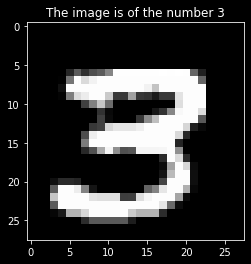

In [6]:
plt.imshow(train[111], cmap = 'gray')
plt.title(f'The image is of the number {label[111]}')
plt.show()

In [7]:
factor1 = np.sqrt(784/2)
factor2 = np.sqrt(49/2)
weights = np.array([ np.random.randn(49,784)/factor1, np.random.randn(10, 49)/factor2], dtype = object)
biases = np.array([ np.zeros((49,1)), np.zeros((10,1))], dtype = object)

In [8]:
def predict(x: np.ndarray, weights, biases):
    """
    This function predicts the label of given image
    """
    input = x.reshape(784,1)
    activations = [relu, softmax]
    for weight, bias, activation  in zip(weights, biases, activations):
        input = weight @ input + bias
        input = activation(input)
    return input.argmax()

def accuracy(x,y, weights, biases):
    """
    This function returns accuracy
    """
    predicted = np.ones(y.shape[0])
    for i in range(len(x)):
        temp = predict(x[i], weights, biases)
        if temp != y[i]:
            predicted[i] = 0
    return np.mean(predicted)        
        
def shuffle(x,y):
    """
    shuffles the input"""
    l = len(x)
    permutation = np.random.permutation(l)
    x = x[permutation]
    y = y[permutation]
    return x,y


In [9]:
def forwardpass(input : np.ndarray, weights: np.ndarray, biases : np.ndarray) -> list:
    """
    This function accepts as input, n x 1 dimensional vector, and an array of weight matrix, bias matrix
    further, it finds the hidden and final output and returns a list of intial, hidden, final layer
    """
    activations = [relu, softmax]
    x_layers = [input]
    for weight, bias, activation  in zip(weights, biases, activations):
        input = weight @ input + bias
        input = activation(input)
        x_layers.append(input)
    return x_layers

In [10]:
def backprop(_input_ : np.ndarray, weights : np.ndarray, biases :np.ndarray, _label_: np.ndarray):
    """
    Returns
    -------
    gradients wrt each matrix, and bias. 
    (np.ndarray for all weight matrix), (np.ndarray for all bias vectors)

    Input
    -----
    one image, weight matrix, biases, label for this image

    What is being done
    ------------------
    input is an array of images of size (28 x 28), first each image is flattended
    
    next, each of the labels is converted to a one-hot vector
    """
    # flattening the image to 784 x 1
    input = _input_.reshape(784,1)
    label = np.zeros((10,1))
    label[_label_] = 1

    # output at each layer
    x_layers = forwardpass(input, weights, biases)
    
    delta1 = x_layers[2] - label
    dw1 = delta1 @ x_layers[1].T
    db1 = delta1
    
    temp = np.ones_like(x_layers[1])
    temp[x_layers[1]<0]=0
    delta0 = (weights[1].T @ delta1) * temp
    
    dw0 = delta0 @ x_layers[0].T
    db0 = delta0

    dw = np.array([dw0, dw1], dtype = object)
    db = np.array([db0, db1], dtype = object)

    return dw, db



In [11]:
# i = backprop(train[0], weights, biases, labels[0])
# i
# i = forwardpass(train[0].reshape(784,1), weights, biases)
# i

In [12]:
def fit( input : np.ndarray, labels : np.ndarray, weights : np.ndarray, biases : np.ndarray, batch_size : int = 50, epochs: int = 10, lr: int = 5):
    
    size = input.shape[0] # number of example in training set
    validation = input[int(size*0.8):]
    validation_labels = labels[int(size*0.8):]

    train = input[:int(size*0.8)]
    labels = labels[:int(size*0.8)]
    
    batches = np.arange(0, train.shape[0], batch_size)

    # print(f'Training accuracy : {accuracy(train, labels, weights, biases)}')
    # print(f'Validation accuracy : {accuracy(validation, validation_labels, weights, biases)}')
    
    for epoch in range(epochs):
        print(f'Epoch #{epoch +1 }:')

        train, labels = shuffle(train, labels)

        for idx in batches:
            x = train[idx: idx+batch_size]
            y = label[idx: idx+batch_size]

            dw, db = None, None
            for xx, yy in zip(x,y):
                if dw is not None:
                    temp1, temp2 = backprop(xx, weights, biases, yy)
                    dw += temp1
                    db += temp2
                else:
                    dw,db = backprop(xx, weights, biases, yy)
            dw /= batch_size
            db /= batch_size
            dw = dw * lr
            db = db * lr
            
            # updating the weights, biases
            weights -= dw
            biases -= db
        print(f'Training accuracy : {accuracy(train, labels, weights, biases)}')
        print(f'Validation accuracy : {accuracy(validation, validation_labels, weights, biases)}\n')
    return weights, biases
    

In [13]:
weights, biases = fit(train[:5000], labels[:5000], weights, biases)

Epoch #1:


/tmp/ipykernel_216913/3672902195.py:27: RuntimeWarning: overflow encountered in exp
  denom = np.sum(np.exp(x))
/tmp/ipykernel_216913/3672902195.py:28: RuntimeWarning: overflow encountered in exp
  return np.exp(x)/denom
/tmp/ipykernel_216913/3672902195.py:28: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(x)/denom


Training accuracy : 0.09475
Validation accuracy : 0.1

Epoch #2:
Training accuracy : 0.09475
Validation accuracy : 0.1

Epoch #3:
Training accuracy : 0.09475
Validation accuracy : 0.1

Epoch #4:
Training accuracy : 0.09475
Validation accuracy : 0.1

Epoch #5:
Training accuracy : 0.09475
Validation accuracy : 0.1

Epoch #6:
Training accuracy : 0.09475
Validation accuracy : 0.1

Epoch #7:
Training accuracy : 0.09475
Validation accuracy : 0.1

Epoch #8:


KeyboardInterrupt: 

In [ ]:
for i,j in zip(train[:10], labels[:10]):
    print(predict(i, weights, biases), j)

0 5
0 0
0 4
0 1
0 9
0 2
0 1
0 3
0 1
0 4
